<a href="https://colab.research.google.com/github/ShuichiroTsuda/Kaggle_Liverpool_Ion_Switching/blob/master/lgb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge, SGDRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error, make_scorer
import lightgbm as lgb
import xgboost as xgb

from functools import partial
import scipy as sp

import time
import datetime

import gc

In [2]:
import json
from google.colab import drive
import os

class ColabKaggle:

    base = 'gdrive/My Drive/'

    def __init__(self):
        drive.mount('gdrive')

    def load_api_key(self, path):
        """
        example of path: path = 'Colab Notebooks/Kaggle/API_setup/kaggle.json'

        """
        path = self.base + path
        with open(path) as f:
            kaggle_api_key = json.load(f)

        filename = "/root/.kaggle/kaggle.json"
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        with open(filename, 'w') as f:
            json.dump(kaggle_api_key, f)

        os.chmod(filename, 600)

        print('API key loaded.')

ck = ColabKaggle()
ck.load_api_key('Colab Notebooks/Kaggle/API_setup/kaggle.json')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive
API key loaded.


In [0]:
train = pd.read_pickle('gdrive/My Drive/Colab Notebooks/Kaggle/Liverpool_Ion_Switching/train1.pkl')
test = pd.read_pickle('gdrive/My Drive/Colab Notebooks/Kaggle/Liverpool_Ion_Switching/test1.pkl')

In [0]:
y = train['open_channels']
col = [c for c in train.columns if c not in ['time', 'open_channels', 'group']]

seed_random = 42

In [0]:
def MacroF1Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average = 'macro')
    return ('MacroF1Metric', score, True)

In [34]:
%%time

X_train, X_valid, y_train, y_valid = train_test_split(train[col], y, test_size=0.3, random_state=seed_random)
params = {'learning_rate': 0.1, 
          'max_depth': -1, 
          'num_leaves': 200,
          'metric': 'logloss', 
          'random_state': seed_random, 
          'n_jobs':-1, 
          'sample_fraction':0.33}

evals_result = {}

model = lgb.train(
            params,
            lgb.Dataset(X_train, y_train), 
            2000, 
            lgb.Dataset(X_valid, y_valid), 
            verbose_eval=10, 
            early_stopping_rounds=200, 
            feval=MacroF1Metric,
            evals_result=evals_result
        )

Training until validation scores don't improve for 200 rounds.
[10]	valid_0's MacroF1Metric: 0.20463
[20]	valid_0's MacroF1Metric: 0.636311
[30]	valid_0's MacroF1Metric: 0.918311
[40]	valid_0's MacroF1Metric: 0.93024
[50]	valid_0's MacroF1Metric: 0.932445
[60]	valid_0's MacroF1Metric: 0.933456
[70]	valid_0's MacroF1Metric: 0.934145
[80]	valid_0's MacroF1Metric: 0.934649
[90]	valid_0's MacroF1Metric: 0.934883
[100]	valid_0's MacroF1Metric: 0.935136
[110]	valid_0's MacroF1Metric: 0.935279
[120]	valid_0's MacroF1Metric: 0.935438
[130]	valid_0's MacroF1Metric: 0.93549
[140]	valid_0's MacroF1Metric: 0.935639
[150]	valid_0's MacroF1Metric: 0.935675
[160]	valid_0's MacroF1Metric: 0.935745
[170]	valid_0's MacroF1Metric: 0.935761
[180]	valid_0's MacroF1Metric: 0.935797
[190]	valid_0's MacroF1Metric: 0.935861
[200]	valid_0's MacroF1Metric: 0.935875
[210]	valid_0's MacroF1Metric: 0.935903
[220]	valid_0's MacroF1Metric: 0.935908
[230]	valid_0's MacroF1Metric: 0.935926
[240]	valid_0's MacroF1Metric

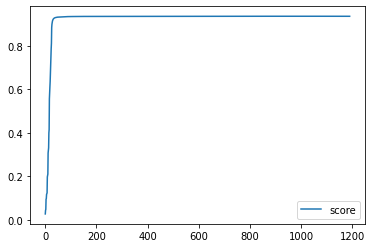

In [37]:
plt.plot(evals_result["valid_0"]["MacroF1Metric"], label="score")
plt.legend()

In [39]:
evals_result.keys()

dict_keys(['valid_0'])

In [38]:
y_lgb_pred = model.predict(test[col], num_iteration=model.best_iteration)
y_pred_train_lgb = model.predict(train[col], num_iteration=model.best_iteration)
gc.collect()

488

In [40]:
print('LGB score {0:.4f}'.format(np.mean(f1_score(y, np.round(np.clip(y_pred_train_lgb,0,10)).astype(int), average="macro"))))

LGB score 0.9522


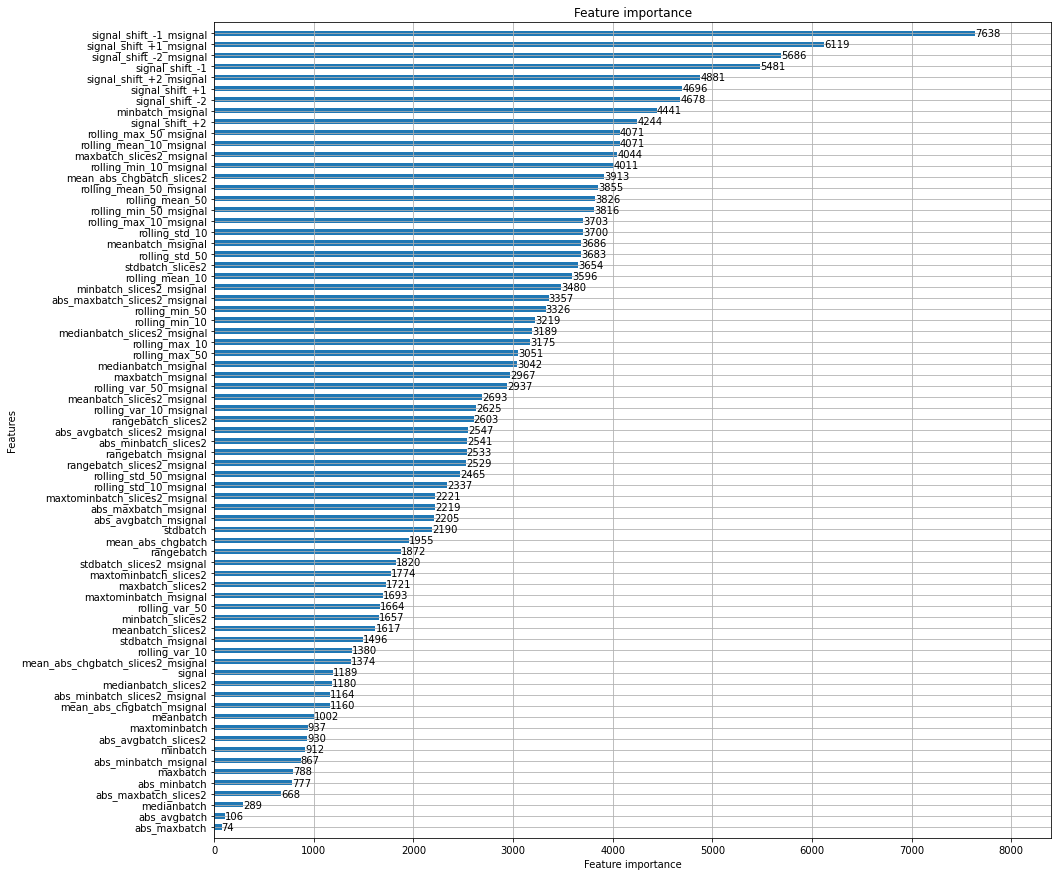

In [41]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(model,ax = axes,height = 0.5)
plt.show();plt.close()

In [0]:
np.save('gdrive/My Drive/Colab Notebooks/Kaggle/Liverpool_Ion_Switching/lgb1',y_pred_train_lgb)

In [0]:
def plot_cm(y_true, y_pred, title):
    figsize=(14,14)
    y_pred = y_pred.astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)


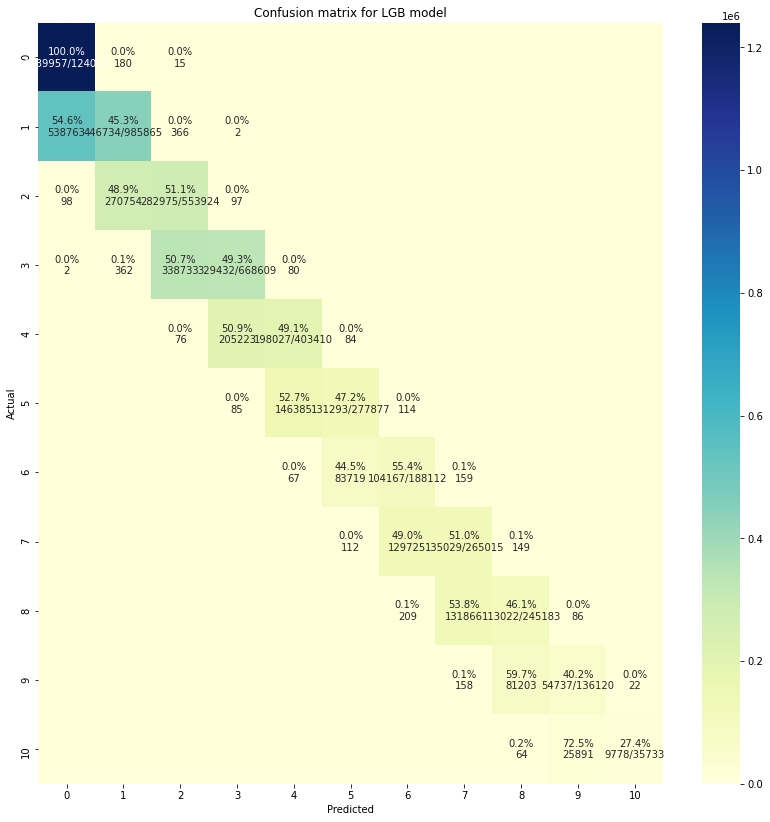

In [44]:
plot_cm(y, y_pred_train_lgb, 'Confusion matrix for LGB model')